<h2>Creazione modello ARIMA su 7357 comuni italiani rispetto a un totale di 7904

<p>Il DataFrame utilizzato contiene i dati relativi ai decessi giornalieri rigistrati dall'ISTAT in 7357 comuni italiani rispetto a un totale di 7904. Il periodo di riferimento va dal <b>1 gennaio 2015 </b> al <b>30 giugno 2020</b>.
    </p>

In [27]:
import pandas as pd
df = pd.read_csv('../csv/serie_storica.csv')
df.head()

,DATA,TOTALE
0,2015-01-01,2508
1,2015-01-02,2079
2,2015-01-03,2107
3,2015-01-04,2135
4,2015-01-05,2199


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2008 entries, 0 to 2007
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   DATA    2008 non-null   object
 1   TOTALE  2008 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 31.5+ KB


In [29]:
df['DATA'] = pd.to_datetime(df['DATA'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2008 entries, 0 to 2007
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   DATA    2008 non-null   datetime64[ns]
 1   TOTALE  2008 non-null   int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 31.5 KB


<h2>Creazione della serie storica

In [30]:
df=df.set_index('DATA')
df.head()

,TOTALE
DATA,
2015-01-01,2508
2015-01-02,2079
2015-01-03,2107
2015-01-04,2135
2015-01-05,2199


In [31]:
ts = df.TOTALE
ts.head()

DATA
2015-01-01    2508
2015-01-02    2079
2015-01-03    2107
2015-01-04    2135
2015-01-05    2199
Name: TOTALE, dtype: int64

<h2>Visualizzazione serie storica

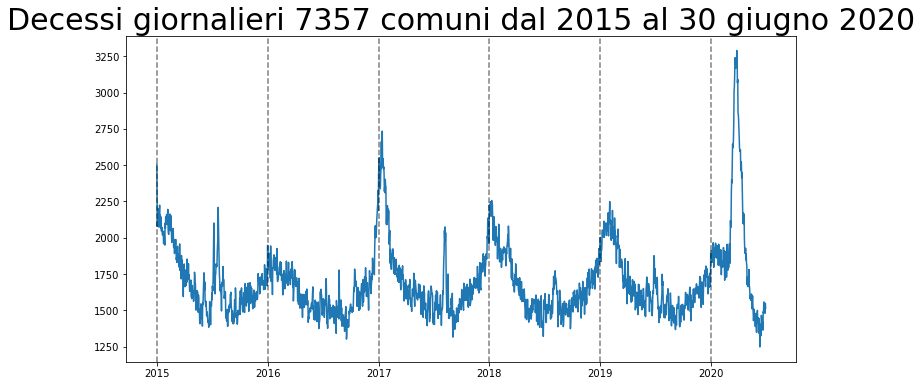

In [32]:
from datetime import datetime
from datetime import timedelta
start_date = datetime(2015,1,1)
end_date = datetime(2020,6,30)
lim_ts = ts[start_date:end_date]


import matplotlib.pyplot as plt
plt.figure(figsize=(12,6))
plt.title('Decessi giornalieri 7357 comuni dal 2015 al 30 giugno 2020', size=30)
plt.plot(lim_ts)
for year in range(start_date.year,end_date.year+1):
    plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.5)

<h2>Decomposizione

Attraverso la funzione `seasonal_decompose()` la serie storica viene decomposta in <b>trend</b>, <b>stagionalità</b> e <b>residui</b>. 

Tramite questo processo è possibile visionare più nel dettaglio l'andamento della serie storica esaminata, con lo scopo d'impiegare le informazioni acquisite per la creazione di un valido modello predittivo. 

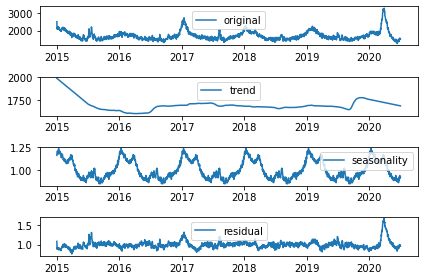

In [33]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ts, period=365, two_sided=True, extrapolate_trend=1, model='multiplicative')

ts_trend = decomposition.trend #andamento della curva
ts_seasonal = decomposition.seasonal #stagionalità 
ts_residual = decomposition.resid #parti rimanenti
plt.subplot(411)
plt.plot(ts,label='original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts_trend,label='trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(ts_seasonal,label='seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(ts_residual,label='residual')
plt.legend(loc='best')
plt.tight_layout()

<h2> Test stazionario </h2>

La modellazione di una serie storica è possibile solo se la serie è <b>stazionaria</b>, ovvero quando le sue proprietà statistiche non variano nel tempo.

La funzione `test_stationarity()` verifica che la serie storica sia stazionaria o meno attraverso il calcolo della <b>Rolling Statistic</b> e del <b>Dickey-Fuller test</b>.

In [34]:
from statsmodels.tsa.stattools import adfuller
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=365).mean()
    rolstd = timeseries.rolling(window=365).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
    else:
        print("X is not stationary")
        

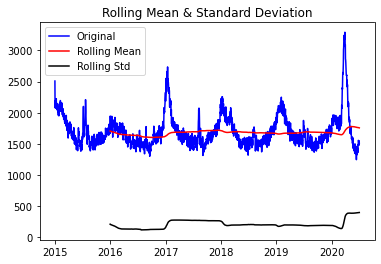

Results of Dickey-Fuller Test:
Test Statistic                -6.766066e+00
p-value                        2.715242e-09
#Lags Used                     0.000000e+00
Number of Observations Used    2.007000e+03
Critical Value (1%)           -3.433612e+00
Critical Value (5%)           -2.862981e+00
Critical Value (10%)          -2.567537e+00
dtype: float64
X is stationary


In [35]:
test_stationarity(ts)

<H2>Autocorrelazione e Autocorrelazione Parziale

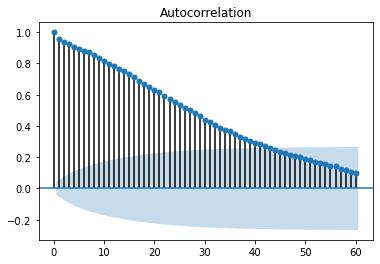

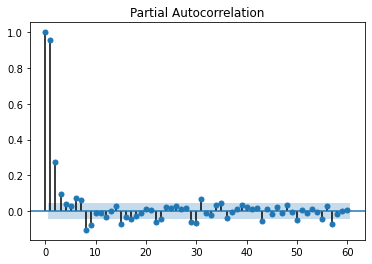

In [36]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(ts, lags =60)
plot_pacf(ts, lags =60)
plt.show()

<h2>Suddivisione della serie storica in train e test

Per poter costruire un modello predittivo è necessario suddividere la <b>serie storica </b> in `train` e `test`. 
<br />
La parte di `train`, che va dal <b>1 gennaio 2015</b> al <b>31 ottobre 2019</b>, sarà impiegata per l'allenamento del modello.
<br />
La parte di `test`, che va dal <b>1 novembre 2019</b> al <b>31 dicembre 2019</b>, sarà impiegata invece per testare la precisione di predizione del modello creato, andando a confrontare la predizione ottenuta con i valori originali della parte `test`.

In [37]:
#suddivisione del trend della serie in train e test
from datetime import datetime
train_end = datetime(2019,10,31)
test_end = datetime (2019,12,31)
covid_end = datetime(2020,4,30)

#TEST: dal 01-01-2015 al 31-10-2019
train = ts[:train_end]

#TRAIN: dal 01-11-2019 al 31-12-2019
test = ts[train_end + timedelta(days=1): test_end]


<h1>CREAZIONE DEL MODELLO

In [38]:
from statsmodels.tsa.arima_model import ARIMA
p = 1
q = 8
d = 0
model = ARIMA(train, order=(p,d,q))
model_fit = model.fit(disp=-1)
print(model_fit.summary())

c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\monta\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\base\tsa_model.py:524: ValueWarning: No frequ

                              ARMA Model Results                              
Dep. Variable:                 TOTALE   No. Observations:                 1765
Model:                     ARMA(1, 8)   Log Likelihood               -9960.640
Method:                       css-mle   S.D. of innovations             68.287
Date:                Wed, 18 Nov 2020   AIC                          19943.281
Time:                        14:20:24   BIC                          20003.516
Sample:                    01-01-2015   HQIC                         19965.538
                         - 10-31-2019                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const         1698.8082     65.566     25.910      0.000    1570.301    1827.316
ar.L1.TOTALE     0.9879      0.004    222.224      0.000       0.979       0.997
ma.L1.TOTALE    -0.3628      0.025    -14.78

<h2>Verifica che i residui del modello siano stazionari

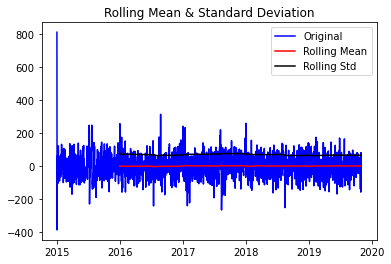

Results of Dickey-Fuller Test:
Test Statistic                  -45.043835
p-value                           0.000000
#Lags Used                        0.000000
Number of Observations Used    1764.000000
Critical Value (1%)              -3.434062
Critical Value (5%)              -2.863180
Critical Value (10%)             -2.567643
dtype: float64
X is stationary


In [39]:
residuals = model_fit.resid
test_stationarity(residuals)

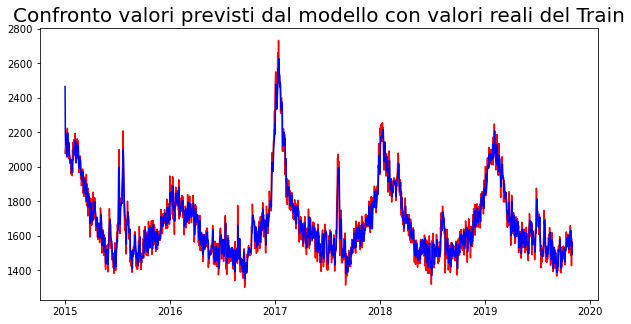

In [40]:
plt.figure(figsize=(10,5))
plt.title('Confronto valori previsti dal modello con valori reali del Train', size=20)
plt.plot (train.iloc[1:], color='red')
plt.plot (model_fit.fittedvalues.iloc[1:], color = 'blue')
plt.show()

<h2>Intervallo di confidenza del modello

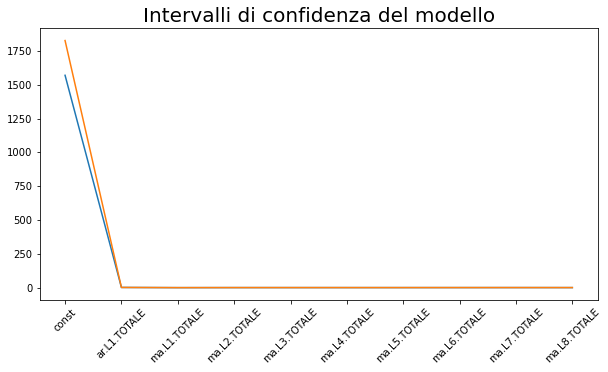

In [41]:
conf = model_fit.conf_int()
plt.figure(figsize=(10,5))
plt.title('Intervalli di confidenza del modello', size=20)
plt.plot(conf)
plt.xticks(rotation=45)
plt.show()

<h2>Predizione del modello sul test

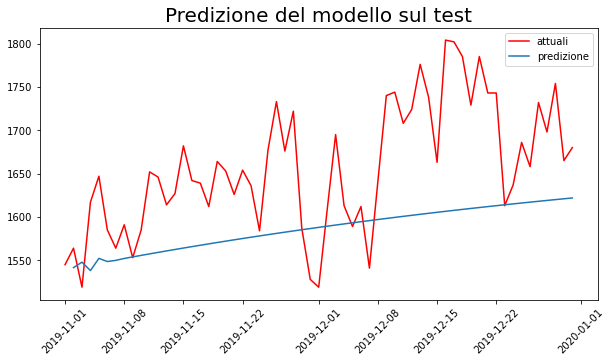

In [42]:
pred_start = test.index[0]
pred_end = test.index[-1]


predictions_test= model_fit.predict(start=pred_start, end=pred_end)


plt.figure(figsize=(10,5))
plt.title('Predizione del modello sul test', size=20)
plt.plot(test, color='red', label='attuali')
plt.plot(predictions_test.iloc[1:], label='predizione' )
plt.xticks(rotation=45)
plt.legend()
plt.show()

<h2>Calcolo RMSE

In [43]:
import numpy as np
from statsmodels.tools.eval_measures import rmse
nrmse = rmse(predictions_test, test)/(np.max(test)-np.min(test))
print('RMSE = ', nrmse)

RMSE =  0.32966089700460804


<h2>Predizione totale

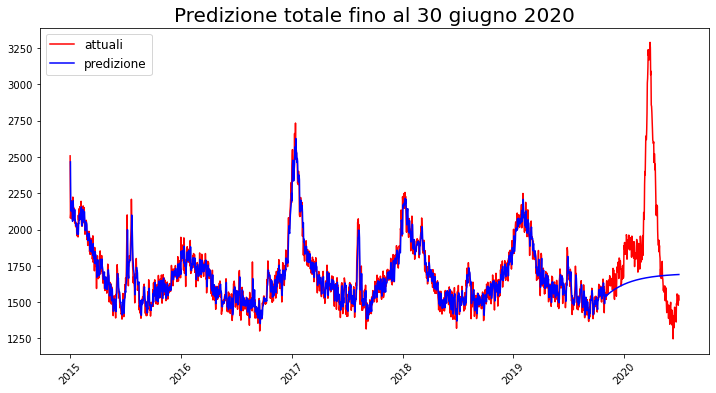

In [48]:
#get prediction start and end dates
start_prediction = ts.index[0]
end_prediction = ts.index[-1]

# predizione sul trend della serie storica includendo il 2020
predictions_tot = model_fit.predict(start=start_prediction, end=end_prediction)

plt.figure(figsize=(12,6))
plt.title('Predizione totale fino al 30 giugno 2020', size=20)
plt.plot(ts, color='red', label='attuali')
plt.plot(predictions_tot.iloc[1:], label='predizione', color='blue')
plt.xticks(rotation=45)
plt.legend(prop={'size': 12})
plt.show()

In [45]:
predictions_tot.to_csv('../csv/predictions_daily_ARIMA_7357comuni.csv')

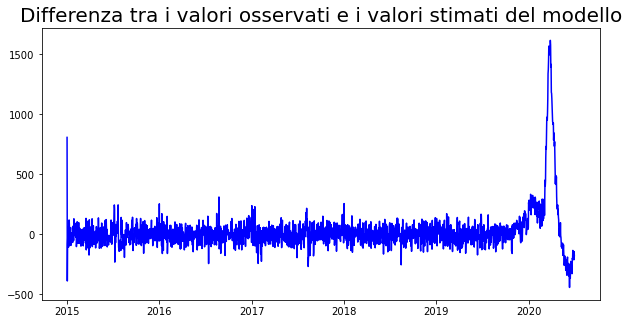

In [46]:
diff_predictions_tot = (ts - predictions_tot)

plt.figure(figsize=(10,5))
plt.title('Differenza tra i valori osservati e i valori stimati del modello', size=20)
plt.plot(diff_predictions_tot, color='blue') 
plt.show()

In [47]:
diff_predictions_tot['24-02-2020':].sum()

38536.881150465415